# An LSTM Neural Net to predict depression, or depression symptoms based on the PHQ-8 from transcribed verbal data 

### Specifically, data are utterances which includes the words uttered (which are replaced with pre-trained embeddings) 

* this code is exploratory, may contain errors!
* python 2 with Tensorflow
* prediction options include: depression level (continuous, low/med/high, or binary), level for each depression symptom based on PHQ-8 (low/med/high, or binary). Need to change the cost function in the code depending on the outcome chosen. 
* data is unbalanced, so options in code for 1) undersampling the majority class (lower levels of depression) and 2) cost-senstive learning
* various options for drop out, L1/L2 regaularization

Unique features of this model compared to other frameworks explored:
* includes embedding layer prior to LSTM layer. Here, the embeddings are pre-trained not learned along the way.
* sequences of various lengths may be used, or a sliding window of words (to increase sample size and variability of utterances)
* debug_sentences allows us to write the sentences in each part of the confusion matrix to a file for later examination of the erors


Alina notes to self:
* data corresponding to IDs without meta-information and data corresponding to missing target information are excluded in Load_Data()
* for variable coding see codebook excel

Helpful tutorials:
* https://github.com/nfmcclure/tensorflow_cookbook/blob/master/09_Recurrent_Neural_Networks/02_Implementing_RNN_for_Spam_Prediction/02_implementing_rnn.py
* Long Short Term Memory paper: http://deeplearning.cs.cmu.edu/pdfs/Hochreiter97_lstm.pdf; Author: Aymeric Damien; Project: https://github.com/aymericdamien/TensorFlow-Examples/    

In [20]:
import os
import re
import io
import requests
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
from zipfile import ZipFile
from tensorflow.python.framework import ops
ops.reset_default_graph()

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import sys
import csv
from collections import deque
from itertools import islice


import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
import statistics
from fractions import Fraction as F
from decimal import Decimal as D

cwd= os.getcwd()

In [237]:
# ==========
#   MODEL
# Some LSTM code and code structure reused from M. Morales
# ==========
class BaseConfiguration:

    def __init__(self):
        self.learning_rate = 0.00001 #also try .001, i think accuracy and confusion matrix could be more stable with lower learning rate
        self.training_iters = 3000000  #was 50,000,000. Consider reducing further if you notice that the testing accuracy becomes stable (or starts dropping) earlier than this number of iterations, to prevent overfitting. 
        self.batch_size = 50
        self.display_step = 1
        self.val_step = 50
        self.L2_penalty= 0.7 #beta term on L2 weight penalty for L2 normalization, if set to 0.0 for no L2 normalization. I think confusion matrix becomes unbalanced (but accuracy higher) with L2 noamlization
        # Network Parameters
        self.seq_max_len = 80 # Sequence max length. In the case of rolling windows, this is also the size of the window (i.e., how many words are in a window)
        self.seq_min_len = 7
        self.embedding_size = 40
        self.n_hidden = 16 # hidden layer num of features, per layer
        self.n_classes = 2 # linear sequence or not
        self.num_layers = 1 #to add more layers: https://r2rt.com/recurrent-neural-networks-in-tensorflow-ii.html
        self.keep_prob = .9 #for no dropout, use 1. This only performs dropout on the LSTM layer, for inputs AND outputs outputs. If config.n_layers>1, dropout will work on every layer, i.e., if set dropout to .9 and 2 layers, total dropout is ,.9*.9
        self.debug_sentences = False #if True, sentences corresponding to each cell in the confusion matrix are written in folder "sentence_validation"
        self.min_word_frequency=15 #wont work well below 15
        self.validation_IDs_proportion=.10 #proportion of IDs (among IDs that exist in meta data, and have the specified target value) that are held out as "validation" data
        self.balance_classes=True #use for balancing classification with undersampling. If True, will only sample the number of the minority category utterances to be same as high utterances (for training data)
        self.step_windows=30 #the step (amt of words to jump) to get to the next rolling windows.  
        self.toss=75 #skip first config.toss words in each transcript to get over small-talk. Best between 50-75 number after reading a few transcripts, could try firsrt 75 or 100 words even

    def printConfiguration(self):
        # print configuration
        print ('---------- Configuration: ----------')
        print ('learning_rate', self.learning_rate)
        print ('training_iters', self.training_iters)
        print ('batch_size', self.batch_size) 
        print ('L2_penalty', self.L2_penalty) 

        # Network Parameters
        print ('seq_max_len', self.seq_max_len )# Sequence max length
        print ('seq_min_len', self.seq_min_len)
        print ('embedding_size', self.embedding_size)
        print ('n_hidden', self.n_hidden) # hidden layer num of features
        print ('n_classes', self.n_classes) # linear sequence or not
        print ('num_layers', self.num_layers)
        print ('keep_prob (dropout = 1-keep_prob)', self.keep_prob)
        print ('------------------------------------')
	#print 'n_hidden: ', self.n_hidden, 'learning rate: ', self.learning_rate, ' batch_size: ', self.batch_size, ' max_len: ', self.seq_max_len, ' min_len: ', self.seq_min_len

# Parameters
# configuration
config = BaseConfiguration()

Reset the tensorflow graph

In [238]:
tf.reset_default_graph() #to reset tensorflow graph if you've already made one graph, once re-set need to run through to get variable agani. 

Set up Tensorflow Graph Input

In [239]:
# tf Graph input
#x = tf.placeholder(tf.float32, [None, config.seq_max_len]) #this plaecholder for x used if pre-trained embeddings are used
y = tf.placeholder(tf.float32, [None, config.n_classes])
x = tf.placeholder(tf.int32, [None, config.seq_max_len]) #this placeholder for x used if training embedding layer

#x = tf.placeholder(tf.float32, [None, config.seq_max_len, config.embedding_size]) #Number of examples, number of input, dimension of each input

keep_prob = tf.placeholder(tf.float32)
# A placeholder for indicating each sequence length
seqlen = tf.placeholder(tf.int32, [None])

# Define weights
weights = {
    'out': tf.Variable(tf.random_normal([config.n_hidden, config.n_classes],seed= 43)) #note weights are initialized as normal random variable
}
biases = {
    'out': tf.Variable(tf.random_normal([config.n_classes], seed= 43))  #note biases are initialized as normal random variable
}

#Define embedding mat:
embedding_weights = tf.Variable(tf.constant(0.0, shape=[len(model.wv.vocab) + 2, 50]),trainable=False)

In [ ]:
#load word2vec model (say from gensim)
import gensim
model = gensim.models.Word2Vec.load('word2vecMODEL_50D_mincount10_10iter_restdefault')

# embedding matrix
#embedding_matrix = model.syn0
#print(type(embedding_matrix)) # numpy.ndarray
#print(embedding_matrix.shape) # (vocab_size, embedding_dim)
# store the embeddings in a numpy array

vocab2id={'UNKNOWN_TOKEN': 3513}
embedding_matrix = np.zeros((len(model.wv.vocab) + 2, 50)) #embeddings are 50-D
for i in range(len(model.wv.vocab)):
    embedding_vector = model.wv[model.wv.index2word[i]]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        vocab2id[model.wv.index2word[i]]= i

embedding_matrix[3513]= np.random.uniform(-0.1,0.1, 50) #this is the 'unknown' word vector
          
#free memory
#del(model)

#model.wv.vocab['1']

# memory efficient way to load the embeddings(avoids several copies of embeddings) in tf


In [82]:
def random_batch(x, y, sequence_length, part_size=0, sentences=None):
    batch_x = []
    batch_y = []
    batch_sequence_length = []
    batch_sentences = []
    indexes = range(len(x))
    random.shuffle(indexes)
    #print(indexes[0:batch_size-1])
    for index in indexes[0:part_size-1]:
        batch_x.append(x[index])
        batch_y.append(y[index])
        batch_sequence_length.append(sequence_length[index])
        if sentences is not None:
            batch_sentences.append(sentences[index])
    return batch_x, batch_y, batch_sequence_length, batch_sentences

def last_relevant(output, length):
    config.batch_size = tf.shape(output)[0]
    max_length = int(output.get_shape()[1])
    output_size = int(output.get_shape()[2])
    index = tf.range(0, config.batch_size) * max_length + (length - 1)
    flat = tf.reshape(output, [-1, output_size])
    relevant = tf.gather(flat, index)
    return relevant

In [83]:
def import_meta_data(path):
    """Imports labels as a dictionary- must designate below which label you want"""
    labels = {}
    # load the CSV file as a numpy matrix
    with open (path,'r') as csv:
        dataset = csv.readlines()
    for row in dataset[1:]:
        ID, depression, dep_binary2, depression_value, depression_level_official, Morethan7PHQsympt_Available,PHQ_9NoInterest,PHQ_9Depressed,PHQ_9Sleep,PHQ_9Tired,PHQ_9Appetite,PHQ_9Failure,PHQ_9Concentrating,PHQ_9Moving,PHQ_9NoInterest_level,PHQ_9Depressed_level,PHQ_9Sleep_level,PHQ_9Tired_level,PHQ_9Appetite_level,PHQ_9Failure_level,PHQ_9Concentrating_level,PHQ_9Moving_level  = row.strip().split(',')
        #map depression strings to int values
        depression_level_official = depression_level_official.strip()
        PHQ_9NoInterest_level = PHQ_9NoInterest_level.strip()
        PHQ_9Depressed_level = PHQ_9Depressed_level.strip()
        PHQ_9Sleep_level = PHQ_9Sleep_level.strip()
        PHQ_9Tired_level = PHQ_9Tired_level.strip()
        PHQ_9Appetite_level = PHQ_9Appetite_level.strip()
        PHQ_9Failure_level = PHQ_9Failure_level.strip()
        PHQ_9Concentrating_level = PHQ_9Concentrating_level.strip()
        PHQ_9Moving_level = PHQ_9Moving_level.strip()
        
        if config.n_classes==2:
            if depression_level_official=='low':
                depression_level_official = 0
            elif depression_level_official=='mid':
                depression_level_official = 1
            elif depression_level_official=='high':
                depression_level_official =1
        
        if config.n_classes==3:
            if depression_level_official=='low':
                depression_level_official = 0
            elif depression_level_official=='mid':
                depression_level_official = 1
            elif depression_level_official=='high':
                depression_level_official =2
        
        if dep_binary2=='0': #need to do this because there are NAs in the data, so it is loaded in as a string not number
            dep_binary2=0
        elif dep_binary2=='1':
            dep_binary2=1
            
        if PHQ_9NoInterest_level=='low':
            PHQ_9NoInterest_level = 0
        elif PHQ_9NoInterest_level=='mid':
            PHQ_9NoInterest_level = 1
        elif PHQ_9NoInterest_level=='high':
            if config.n_classes==2:
                PHQ_9NoInterest_level =1
            elif config.n_classes==3:
                PHQ_9NoInterest_level =2    
       
        if PHQ_9Depressed_level=='low':
            PHQ_9Depressed_level = 0
        elif PHQ_9Depressed_level=='mid':
            PHQ_9Depressed_level = 1
        elif PHQ_9Depressed_level=='high':
            if config.n_classes==2:
                PHQ_9Depressed_level =1
            elif config.n_classes==3:
                PHQ_9Depressed_level =2     
            
        if PHQ_9Sleep_level=='low':
            PHQ_9Sleep_level = 0
        elif PHQ_9Sleep_level=='mid':
            PHQ_9Sleep_level = 1
        elif PHQ_9Sleep_level=='high':
            if config.n_classes==2:
                PHQ_9Sleep_level =1
            elif config.n_classes==3:
                PHQ_9Sleep_level =2     
    
        if PHQ_9Tired_level=='low':
            PHQ_9Tired_level = 0
        elif PHQ_9Tired_level=='mid':
            PHQ_9Tired_level = 1
        elif PHQ_9Tired_level=='high':
            if config.n_classes==2:
                PHQ_9Tired_level =1
            elif config.n_classes==3:
                PHQ_9Tired_level =2     
            
        if PHQ_9Appetite_level=='low':
            PHQ_9Appetite_level = 0
        elif PHQ_9Appetite_level=='mid':
            PHQ_9Appetite_level = 1
        elif PHQ_9Appetite_level=='high':
            if config.n_classes==2:
                PHQ_9Appetite_level =1
            elif config.n_classes==3:
                PHQ_9Appetite_level=2      
            
        if PHQ_9Failure_level=='low':
            PHQ_9Failure_level = 0
        elif PHQ_9Failure_level=='mid':
            PHQ_9Failure_level = 1
        elif PHQ_9Failure_level=='high':
            if config.n_classes==2:
                PHQ_9Failure_level =1
            elif config.n_classes==3:
                PHQ_9Failure_level =2      
            
        if PHQ_9Concentrating_level=='low':
            PHQ_9Concentrating_level = 0
        elif PHQ_9Concentrating_level=='mid':
            PHQ_9Concentrating_level = 1
        elif PHQ_9Concentrating_level=='high':
            if config.n_classes==2:
                PHQ_9Concentrating_level =1
            elif config.n_classes==3:
                PHQ_9Concentrating_level =2     
        
        if PHQ_9Moving_level=='low':
            PHQ_9Moving_level = 0
        elif PHQ_9Moving_level=='mid':
            PHQ_9Moving_level = 1
        elif PHQ_9Moving_level=='high':
            if config.n_classes==2:
                PHQ_9Moving_level =1
            elif config.n_classes==3:
                PHQ_9Moving_level =2     
        
        labels[ID.strip()] = [depression, dep_binary2, depression_value, depression_level_official,PHQ_9NoInterest_level,PHQ_9Depressed_level,PHQ_9Sleep_level,PHQ_9Tired_level,PHQ_9Appetite_level,PHQ_9Failure_level,PHQ_9Concentrating_level,PHQ_9Moving_level]
    return labels

#meta_data = import_meta_data('Meta_Data_with_Symptoms.csv')
#meta_data['311']

In [240]:
data_file_path= cwd + '/REcleaned_utterances_data_July2017/Cleaned_Utterances_by_ID/'

#load utterances data
utterances=[]
IDs_list= []

files= os.listdir(data_file_path)
#files= ['Utterances771.txt', 'Utterances300.txt']
lengths=[]

for ppt_file in files:
    path= data_file_path + str(ppt_file)
    f = io.open(path,'r', encoding='utf8')
    lines =  [line.strip() for line in f.readlines()]
    lines= " ".join(lines)
    lines= lines.split()
    lines= [word.strip() for word in lines] 
    lines= [word for word in lines if word in vocab2id.keys()] #makes this go VERY slowly, but better than having many missing values?
    if len(lines) > ((config.toss+config.seq_max_len) -1):
        skip=config.toss
        utterances.append(lines[skip:]) #skip first config.toss words to get over small-talk. chose this number after reading a few transcripts, could try firsrt 75 or 100 words even
        ID=re.sub('Utterances', '', ppt_file)
        ID=re.sub('.txt', '', ID)
        IDs_list.append(ID)
        lengths.append(len(lines))
    f.close()

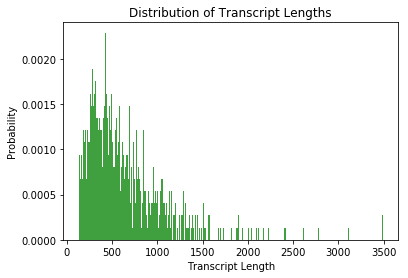

Mean, Median, Min, and Max transript lengths: 641.129909366 526.0 128 3491


In [218]:
plt.hist(lengths, 300, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Transcript Length')
plt.ylabel('Probability')
plt.title('Distribution of Transcript Lengths')
plt.show()

low=0
print('Mean, Median, Min, and Max transript lengths:', statistics.mean(lengths), statistics.median(lengths), min(lengths), max(lengths))
for i in lengths:
    if i<200:
        low=low+1

In [241]:
#adjusted from: https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator-in-python
def sliding_window(iterable, size, step, fillvalue=' '):
    if size < 0 or step < 1:
        raise ValueError
    it = iter(iterable) #list of the words in the transcript
    q = deque(islice(it, size), maxlen=size)
    if not q:
        return  # empty iterable or size == 0
    q.extend(fillvalue for _ in range(size - len(q)))  # pad to size
    while True:
        yield iter(q)  # iter() to avoid accidental outside modifications
        try:
            q.append(next(it))
        except StopIteration:
            return
        q.extend(next(it) for _ in range(step - 1))

utterances_seqs=[]
for i in range(0,len(utterances)):
    for j in sliding_window(utterances[i], config.seq_max_len, config.step_windows):
        listy= ' '.join(list(j))
        listy= listy + ',' + str(IDs_list[i])
        listy= ''.join(listy).split(',')
        utterances_seqs.append(listy)

In [242]:
missing_meta=[] #this is just for inspecting IDs that aren't in the meta-data file, and so not used in RNN code
IDs_NAs_inMeta=[] #this is just for inspecting IDs that are in the meta-data file but don't have target values, so not used in RNN code

def load_data(target=None, meta_file_path='Meta_Data_with_Symptoms.csv'):

    if target is None:
        print("Target not specified: possible target classes: depression_binary=0, dep_binary2=1, depression value=2, depression_level_official=3, PHQ_9NoInterest_level=4,PHQ_9Depressed_level=5,PHQ_9Sleep_level=6,PHQ_9Tired_level=7,PHQ_9Appetite_level=8,PHQ_9Failure_level=9,PHQ_9Concentrating_level=10,PHQ_9Moving_level=11")
        raise
    #get labels
    meta_data = import_meta_data(meta_file_path)
    
    #training data variables
    utterances_withIDs = [] #utterances of training data with meta data (ID of speaker, line in transcript, and quarter of transcript)
    data_y = [] #this will be an array with an element for each sentence in the training data, with the depression label, in the format [X,X,X] 
    sequence_length = [] #vector of sequence lengths for each utterances in the training data
    sentences = [] #just the utterances of training data, no meta data included 
    IDs = [] #training IDs
    Nlow_utterances=[] #number of utterances from those in training category with low depression, used to balance cost function
    Nmid_utterances=[] #number of utterances from those in training category with mid depression, used to balance cost function
    Nhigh_utterances=[] #number of utterances from those in training category with high depression, used to balance cost function
    
    #validation data variables
    utterances_validation=[]  #utterances of validation data with meta data (ID of speaker, line in transcript, and quarter of transcript)
    validation_y =[]  #this will be an array with an element for each sentence in the validation data, with the depression label, in the format [X,X,X] 
    sequence_length_validation=[] #vector of sequence lengths for each utterances in the training data
    sentences_validation=[] #just the utterances of validation data, no meta data included 
    IDs_validation=[] #list of validation IDs so that validation ID's are excluded from training data, and it is in same order as the utterances, sentences, sequence length, y, etc. 
    
    #get validation IDs, and list them in validation_IDs_set
    IDs_noNAs_inMeta=[] #list of IDs in sentences that have corresponding meta data and have the specified target value
    for L in utterances_seqs:
        ID = L[1].strip() 
        try:
            meta = meta_data[ID]
            if meta[target] != 'NA':
                IDs_noNAs_inMeta.append(ID)
            else:
                IDs_NAs_inMeta.append(ID) #just in case want to track who was excluded
        except:
            missing_meta.append(ID)
            continue       
    validation_IDs_set= random.sample(set(IDs_noNAs_inMeta), int(round(config.validation_IDs_proportion*len(set(IDs_noNAs_inMeta))))) #get number of IDs for validation set based on the proportion set in the configuration, round the number to nearest integer
    
    #fill in variables for utterances (i.e, sentences with meta info), sentences, IDs, and sequence lengths (for training and validation sets separately)
    utterances_withIDs_low=[] #this can be used to sample among utterances for "low" depression
    utterances_withIDs_mid=[] #this can be used to sample among utterances for "mid" depression

    for L in utterances_seqs:
        ID = L[1].strip() 

        L[0]= L[0].split(" ")
        L[0]= [word.lower() for word in L[0]]
        length = len(L[0]) #each line is for example: ['me there at all can you do it at home', ' 602', '1', 'first quarter'], so the 0th item is the words, this is measuring characters, if want to measure words split here split.("\\s+")

        minimum_seqs= config.seq_min_len-1 #such that the minimum length in the next line is inclusive of the minimum number itself (e.g. if minimum sequence length is 6 words then sequences of 6 will be included)
        
        if length > minimum_seqs: #this should always be the case, since moving window method used
            try:
                meta = meta_data[ID]
                if meta[target] == 0: #exclude participants without data for the specific target
                    if ID not in validation_IDs_set: #IDs in validation set are EXCLUDED from variables below
                        utterances_withIDs_low.append(L) # can sample among these,below #this is a list of [utterance, id] for each utterance. but only includes those corresponding to indivduals with valid ids
                    else:
                        sentences_validation.append(L[0]) 
                        utterances_validation.append(L) 
                        IDs_validation.append(ID)
                        sequence_length_validation.append(length)
                elif meta[target] ==1: #exclude participants without data for the specific target
                    if ID not in validation_IDs_set: #IDs in validation set are EXCLUDED from variables below
                        utterances_withIDs_mid.append(L) #this is a list of [utterance, id] for each utterance. but only includes those corresponding to indivduals with valid ids
                    else:
                        sentences_validation.append(L[0]) 
                        utterances_validation.append(L) 
                        IDs_validation.append(ID)
                        sequence_length_validation.append(length)
                elif meta[target] ==2: #exclude participants without data for the specific target
                    if ID not in validation_IDs_set: #IDs in validation set are EXCLUDED from variables below
                        sentences.append(L[0]) #now this is a list of utterances coresponding to indivdiuals with valid IDs
                        utterances_withIDs.append(L) #this is a list of [utterance, id] for each utterance. but only includes those corresponding to indivduals with valid ids
                        IDs.append(ID)
                        sequence_length.append(length)
                    else:
                        sentences_validation.append(L[0]) 
                        utterances_validation.append(L) 
                        IDs_validation.append(ID)
                        sequence_length_validation.append(length)
            except:
                #print('invalid ID: ', ID)
                continue
    
    #this is where the "low" (for 2 or 3 class predictions) and "mid" (for 3 class predictions) level depression setences may be undersampled
    if config.balance_classes==True:
        if config.n_classes==2:
            try:
                #try this, will throw and exception for a few PHQ symptoms which are imbalanced other way and have more mid than low
                utterances_withIDs_low= random.sample(utterances_withIDs_low, len(utterances_withIDs_mid)) 
            except:
                utterances_withIDs_mid= random.sample(utterances_withIDs_mid, len(utterances_withIDs_low)) 

        elif config.n_classes==3: #CHECK BEFORE USING
            utterances_withIDs_low= random.sample(utterances_withIDs_low, len(utterances_withIDs))
            utterances_withIDs_mid= random.sample(utterances_withIDs_mid, len(utterances_withIDs)) 
            
    for L in utterances_withIDs_low:
        ID = L[1].strip()    
        length = len(L[0]) #each line is for example: ['me there at all can you do it at home', ' 602', '1', 'first quarter'], so the 0th item is the words, this is measuring characters, if want to measure words split here split.("\\s+")
        sentences.append(L[0]) #now this is a list of utterances coresponding to indivdiuals with valid IDs
        utterances_withIDs.append(L) 
        IDs.append(ID)
        sequence_length.append(length)
    
    for L in utterances_withIDs_mid:
        ID = L[1].strip()    
        length = len(L[0]) #each line is for example: ['me there at all can you do it at home', ' 602', '1', 'first quarter'], so the 0th item is the words, this is measuring characters, if want to measure words split here split.("\\s+")
        sentences.append(L[0]) #now this is a list of utterances coresponding to indivdiuals with valid IDs
        utterances_withIDs.append(L) 
        IDs.append(ID)
        sequence_length.append(length)
    #fill in re-shaped labels variables (for training and validation separately, and do depending on the number of classes- 2 or 3)
    if config.n_classes==2:
        for L in utterances_withIDs:
            ID = L[1].strip()
            meta = meta_data[ID]
            if meta[target]==0:
                data_y.append([1.0, 0.0]) 
                Nlow_utterances.append(1)
            elif meta[target] == 1:
                data_y.append([0.0, 1.0])
                Nmid_utterances.append(1)

    if config.n_classes==3:
        for L in utterances_withIDs:
            ID = L[1].strip()
            meta = meta_data[ID]
            if meta[target]==0:
                data_y.append([1.0, 0.0, 0.0]) 
                Nlow_utterances.append(1)
            elif meta[target] == 1:
                data_y.append([0.0, 1.0, 0.0])
                Nmid_utterances.append(1)
            elif meta[target] == 2:
                data_y.append([0.0, 0.0, 1.0]) #for binary depression categorization, this else should be ignored by default
                Nhigh_utterances.append(1)
    
    if config.n_classes==2:
        for L in utterances_validation:
            ID = L[1].strip()
            meta = meta_data[ID]
            if meta[target]==0:
                validation_y.append([1.0, 0.0]) #need labels in this shape for the RNN
            elif meta[target] == 1:
                validation_y.append([0.0, 1.0])
        
    if config.n_classes==3:
        for L in utterances_validation:
            ID = L[1].strip()
            meta = meta_data[ID]
            if meta[target]==0:
                validation_y.append([1.0, 0.0, 0.0]) #need labels in this shape for the RNN
            elif meta[target] == 1:
                validation_y.append([0.0, 1.0, 0.0])
            elif meta[target] == 2:
                validation_y.append([0.0, 0.0, 1.0]) 
    
    sentences_processed=[]
    for L in sentences:
        newline=[]
        for word in L:
            try:
                newline.append(vocab2id[word])
            except:
                newline.append(3513) #unknown token if not in vocabulary
        sentences_processed.append(newline)
    
    sentences_validation_processed=[]
    for L in sentences_validation:
        newline=[]
        for word in L:
            try:
                newline.append(vocab2id[word])
            except:
                newline.append(3513) #unknown token if not in vocabulary
        sentences_validation_processed.append(newline)
    vocab_size=len(vocab2id)
    return sentences_processed, data_y, sequence_length, IDs, vocab_size, sentences, len(Nlow_utterances), len(Nmid_utterances), len(Nhigh_utterances), sentences_validation_processed, validation_y, sequence_length_validation, IDs_validation,sentences_validation, utterances_validation

In [243]:
dcaps_data, dcaps_label, dcaps_sequence_lengths, dcaps_IDs, vocab_size, dcaps_sentences, N_low, N_mid, N_high, validation_x, validation_y, sequence_length_validation, IDs_validation,sentences_validation, utterances_validation = load_data(target=3) #this needs to be before creating RNN object, since the vocab size is needed to specify the dimensions of the embedding in the RNN 

In [244]:
check_numbers= (dcaps_data, dcaps_label, dcaps_sequence_lengths, dcaps_IDs, dcaps_sentences, validation_x, validation_y, sentences_validation, utterances_validation, sequence_length_validation)
for i in check_numbers:
    print(len(i))
    

5566
5566
5566
5566
5566
1183
1183
1183
1183
1183


In [245]:
print(N_low, N_mid, N_high)

2783 2783 0


In [36]:
"""
#plot out training data sequence lengths
plt.hist(dcaps_sequence_lengths, 50, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Sequence Length')
plt.ylabel('Probability')
plt.title('Distribution of truncated training sequence lengths')
plt.show()
"""

"\n#plot out training data sequence lengths\nplt.hist(dcaps_sequence_lengths, 50, normed=1, facecolor='green', alpha=0.75)\nplt.xlabel('Sequence Length')\nplt.ylabel('Probability')\nplt.title('Distribution of truncated training sequence lengths')\nplt.show()\n"

In [202]:
def write_debug_sentences(val_predictions, valBatch_y, iteration, val_probs, valBatch_sentences):
    os.makedirs('sentence_validation' + str(iteration))
    if config.n_classes==2:
        with open('sentence_validation' + str(iteration) + '/conf_11.log', 'w') as f11, open('sentence_validation' + str(iteration) + '/conf_12.log', 'w') as f12, open('sentence_validation' + str(iteration) + '/conf_21.log', 'w') as f21, open('sentence_validation' + str(iteration) + '/conf_22.log', 'w') as f22:
            files = []
            files.append(f11)
            files.append(f12)
            files.append(f21)
            files.append(f22)

            for i, val in enumerate(val_predictions):
                file_idx = config.n_classes*val + np.argmax(valBatch_y[i])
                files[file_idx].write(valBatch_sentences[i]+ ',' + str(val_prob_predictions[i][0]) + ',' + str(val_prob_predictions[i][1]) + '\n') 
           
    if config.n_classes==3:
        with open('sentence_validation' + str(iteration) + '/conf_11.log', 'w') as f11, open('sentence_validation' + str(iteration) + '/conf_12.log', 'w') as f12, open('sentence_validation' + str(iteration) + '/conf_13.log', 'w') as f13, open('sentence_validation' + str(iteration) + '/conf_21.log', 'w') as f21, open('sentence_validation' + str(iteration) + '/conf_22.log', 'w') as f22, open('sentence_validation' + str(iteration) + '/conf_23.log', 'w') as f23, open('sentence_validation' + str(iteration) + '/conf_31.log', 'w') as f31, open('sentence_validation' + str(iteration) + '/conf_32.log', 'w') as f32, open('sentence_validation' + str(iteration) + '/conf_33.log', 'w') as f33:
            files = []
            files.append(f11)
            files.append(f12)
            files.append(f13)
            files.append(f21)
            files.append(f22)
            files.append(f23)
            files.append(f31)
            files.append(f32)
            files.append(f33)
        
            for i, val in enumerate(val_predictions):
                file_idx = config.n_classes*val + np.argmax(valBatch_y[i])
                files[file_idx].write(valBatch_sentences[i]+ ',' + str(val_prob_predictions[i][0]) + ',' + str(val_prob_predictions[i][1]) + ',' + str(val_prob_predictions[i][2]) + '\n') 
    
    for thefile in files:
        thefile.close()

In [203]:
def write_debug_sentences_training(all_training_predictions, all_training_y, iteration, all_training_prob_predictions, all_training_IDs):
    os.makedirs('sentence_training' + str(iteration))
    if config.n_classes==2:
        with open('sentence_training' + str(iteration) + '/conf_11.log', 'w') as f11, open('sentence_training' + str(iteration) + '/conf_12.log', 'w') as f12, open('sentence_training' + str(iteration) + '/conf_21.log', 'w') as f21, open('sentence_training' + str(iteration) + '/conf_22.log', 'w') as f22:
            files = []
            files.append(f11)
            files.append(f12)
            files.append(f21)
            files.append(f22)

            for i, val in enumerate(all_training_predictions):
                file_idx = config.n_classes*val + np.argmax(all_training_y[i])
                files[file_idx].write(str(all_training_IDs[i]) + ',' + str(all_training_prob_predictions[i][0]) + ',' + str(all_training_prob_predictions[i][1]) + '\n') 
    
    if config.n_classes==3:
        with open('sentence_training' + str(iteration) + '/conf_11.log', 'w') as f11, open('sentence_training' + str(iteration) + '/conf_12.log', 'w') as f12, open('sentence_training' + str(iteration) + '/conf_13.log', 'w') as f13, open('sentence_validation_training' + str(iteration) + '/conf_21.log', 'w') as f21, open('sentence_training' + str(iteration) + '/conf_22.log', 'w') as f22, open('sentence_validation_training' + str(iteration) + '/conf_23.log', 'w') as f23, open('sentence_training' + str(iteration) + '/conf_31.log', 'w') as f31, open('sentence_training' + str(iteration) + '/conf_32.log', 'w') as f32, open('sentence_training' + str(iteration) + '/conf_33.log', 'w') as f33:
            files = []
            files.append(f11)
            files.append(f12)
            files.append(f13)
            files.append(f21)
            files.append(f22)
            files.append(f23)
            files.append(f31)
            files.append(f32)
            files.append(f33)
        
            for i, val in enumerate(all_training_predictions):
                file_idx = config.n_classes*val + np.argmax(all_training_y[i])
                files[file_idx].write(str(all_training_prob_predictions[i][0]) + ',' + str(all_training_prob_predictions[i][1]) + ',' + str(all_training_predictions[i][2]) + '\n') 
    
    for thefile in files:
        thefile.close()

In [246]:
#W = tf.Variable(tf.constant(0.0, shape=[vocab_size, 50]), trainable=False, name="W")
#embedding_placeholder = tf.placeholder(tf.float32, [vocab_size, embedding_dim])
#embedding_init = W.assign(embedding_placeholder)

def dynamicRNN(x, seqlen, weights, biases, vocab_size, keep_prob):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Permuting batch_size and n_steps
    #print(x.get_shape())
    #x = tf.transpose(x, [1, 0, 2])
    # Reshaping to (n_steps*batch_size, n_input)
    # print(x.get_shape())
    # x = tf.reshape(x, [-1, 300])
    # print(x.get_shape())
    # Split to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    # x = tf.split(0, seq_max_len, x)
    # print(len(x), x[0].get_shape())
    #x = tf.squeeze(x)
    #print(x.get_shape())
    
    #need to input dat in: batch_size, n_steps
    with tf.device("/cpu:0"): #http://www.wildml.com/2015/12/implementing-a-cnn-for-text-classification-in-tensorflow/
        # set embeddings
        embedding_output = tf.nn.embedding_lookup(embedding_weights, x)

    #The result of the embedding operation is a 3-dimensional tensor of shape [None, sequence_length, embedding_size].

    
    # Define a lstm cell with tensorflow
    if config.num_layers == 1:
        lstm_cell = tf.contrib.rnn.BasicLSTMCell(config.n_hidden)
        if config.keep_prob < 1:
            lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob, input_keep_prob=keep_prob) #might also add input_keep_prob
        #init_state = lstm_cell.zero_state(config.batch_size, tf.float32)    
    else:    
        def lstm_cell():
            return tf.contrib.rnn.BasicLSTMCell(config.n_hidden, reuse=tf.get_variable_scope().reuse)
        lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(config.num_layers)], state_is_tuple = True)
        if config.keep_prob <1:
            def lstm_cell():
                return tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(config.n_hidden), output_keep_prob=keep_prob, input_keep_prob=keep_prob)
            lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell() for _ in range(config.num_layers)], state_is_tuple = True)

        #lstm_cell = tf.contrib.rnn.BasicLSTMCell(config.n_hidden, reuse=tf.get_variable_scope().reuse)
        
        #init_state = lstm_cell.zero_state(config.batch_size, tf.float32)            
        
                            
    # Get lstm cell output, providing 'sequence_length' will perform dynamic
    # calculation.
    outputs, states = tf.nn.dynamic_rnn(lstm_cell, embedding_output, dtype=tf.float32, sequence_length=seqlen)

    # When performing dynamic calculation, we must retrieve the last
    # dynamically computed output, i.e, if a sequence length is 10, we need
    # to retrieve the 10th output.
    # However TensorFlow doesn't support advanced indexing yet, so we build
    # a custom op that for each sample in batch size, get its length and
    # get the corresponding relevant output.
    output = tf.transpose(outputs, [1, 0, 2])
    last = tf.gather(output, int(output.get_shape()[0]) - 1)
    # 'outputs' is a list of output at every timestep, we pack them in a Tensor
    # and change back dimension to [batch_size, n_step, n_input]
    # print('output_shape:', outputs.get_shape())
    # print('states_shape:', states.get_shape())
    # outputs = tf.pack(outputs)
    # tf.Print(outputs, [outputs], message='outputs', summarize=100)
    # print(outputs.get_shape())
    # outputs = tf.transpose(outputs, [1, 0, 2])
    # print(outputs.get_shape())
    #output = last_relevant(outputs, seqlen)
    # output = tf.Print(output, [output], message='last relevant output', summarize=100)
    # Hack to build the indexing and retrieve the right output.
    #batch_size = tf.shape(outputs)[0]
    #print(batch_size.get_shape())
    # Start indices for each sample
    #index = tf.range(0, batch_size) * seq_max_len + (seqlen - 1)
    #print(index.get_shape())
    # Indexing
    #outputs = tf.gather(tf.reshape(outputs, [-1, n_hidden]), index)
    #print(outputs.get_shape())
    # Linear activation, using outputs computed above
    #print(output.get_shape())
    return tf.matmul(last, weights['out']) + biases['out']

In [247]:
pred = dynamicRNN(x, seqlen, weights, biases, vocab_size, keep_prob) #returns a tensor [#, #, #] with LOGITS for each class, only become probabilities when fed into softmax function
#pred = tf.Print(pred, [weights['out']], message='weights', summarize=10)
#print(pred.get_shape(), y.get_shape())
#pred = tf.Print(pred, [pred], message='predictions', summarize=100)

In [250]:
prob = tf.nn.softmax(pred) #get probabilities as a variable, so they can be added in and analyzed later
predictions = tf.cast(tf.argmax(pred,1), tf.int64) #a_note, returns the index with the largest value across axis of a tensor, i.e., the predicted class as 1/2/3
labels = tf.cast(tf.argmax(y,1), tf.int64) #a_note, returns the index with the largest value across axis of a tensor, i.e., the expected class as 1/2/3
conf_mat = tf.confusion_matrix(labels, predictions) #confusion matrix, where each row is a label, col is a prediction. 

###################################

# Define loss and optimizer


#FOR COST-SENSITIVE LEARNING:
#####use Cost-sensitive learning if proportion of classes in data is very unbalanced (under samping the majority class is another approach). Create and add weights to labels for cost-sensitive learning, where the cost is magnified for certain observations, such as those which occur frequently. Example followed: https://github.com/jakeret/tf_unet/blob/master/tf_unet/unet.py#L191

'''
if config.n_classes==2:
    prop_low = (N_low+N_mid)/N_low #calculate weights, which are the proportion of each class
    prop_mid = (N_low+N_mid)/N_mid 
    classes_weights = tf.constant([prop_low, prop_mid],  dtype=np.float32) #weighted contributions of each class, so that we can penalize extra when a sentences is mistakenly put in the majority class. otherwise the most 'accurate' strategy in unbalanced data is to predict everthing as the majority class 
if config.n_classes==3: 
    prop_low = (N_low+N_mid+N_high)/N_low #calculate weights, which are the proportion of each class
    prop_mid = (N_low+N_mid+N_high)/N_mid 
    prop_high = (N_low+N_mid+N_high)/N_high #consider increaseing penalty by muliptlying N_high*.7 or another value
    classes_weights = tf.constant([prop_low, prop_mid, prop_high],  dtype=np.float32) #weighted contributions of each class, so that we can penalize extra when a sentences is mistakenly put in the majority class. otherwise the most 'accurate' strategy in unbalanced data is to predict everthing as the majority class 

#weighted_logits = tf.multiply(pred, classes_weights) #could use weighted_logits instead of weighted preds in cost function

flat_pred = tf.reshape(pred, [-1, config.n_classes])
flat_labels = tf.reshape(y, [-1, config.n_classes])
weight_map1 = tf.multiply(flat_labels, classes_weights )
weight_map = tf.reduce_sum(weight_map1, axis=1) #sum weighted predictions

#weighted cost
loss_map= tf.nn.softmax_cross_entropy_with_logits(labels=flat_labels, logits=flat_pred) #shape [1, batch_size] #get loss
weighted_cost1= tf.multiply(loss_map, weight_map) #weight the loss by the summed, weighted predictions (why? multiplies loss from rarer events by larger factor, so they won't just be put in the most common class. )
cost = tf.reduce_mean(weighted_cost1) #shape 1; returns the mean of weighted losses

'''
#FOR NON-COST SENSITIVE LEARNING:

######L2 REGULARIZATION. But if config.L2_penalty is 0 this reduces to no L2 regularization: Not 100% confident in code yet, so keep at 0. 
reg= tf.nn.l2_loss(weights['out'])
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits= pred)) + config.L2_penalty*reg # this loss in middle is the addded loss plus L2 penalty term. why? shouldnt the mean cost be added to the regualrized mean weights?

#OPTIMIZER
optimizer = tf.train.AdamOptimizer(learning_rate=config.learning_rate).minimize(cost)


#######################################

# Evaluate model
#pred = tf.Print(pred, [tf.argmax(pred, 1), tf.argmax(y,1)], message='crisp_prediction', summarize=100)
correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


# Initializing the variables
init =  tf.global_variables_initializer() #tf.initialize_all_variables()

#Create a saver object which will save all the variables. From: https://stackoverflow.com/questions/33759623/tensorflow-how-to-save-restore-a-model
saver = tf.train.Saver()

In [265]:
# Launch the graph
with tf.Session() as sess:
    sess.run(init)
    # override inits
    sess.run(embedding_weights.assign(embedding_matrix))

    #saver = tf.train.Saver()
    step = 1
    moving_avg_loss = 0.0
    moving_avg_acc = 0.0
    discount = 0.01
    batch_siz = config.batch_size #250

    config.printConfiguration()
    # print(type(batch_siz), type(config.training_iters))
    # load DCAPS Data
    
    #dcaps_pdha_data, dcaps_pdha_label, dcaps_pdha_sequence_lengths, dcaps_pdha_sentences, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_PDHA_fisherEmbeddings.csv')
    #dcaps_frame_data, dcaps_frame_label, dcaps_frame_sequence_lengths, _, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_Framing_fisherEmbeddings.csv')
    #dcaps_wozai_data, dcaps_wozai_label, dcaps_wozai_sequence_lengths, dcaps_wozai_sentences, _ = load_data(target=4, data_file_path='features/sequences/WoZAI_fisherEmbeddings.csv')
    
    #dcaps_data, dcaps_label, dcaps_sequence_lengths, _ = load_data(target=4)
    #dcaps_pdha_data, dcaps_pdha_label, dcaps_pdha_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_PDHA.csv')
    #dcaps_frame_data, dcaps_frame_label, dcaps_frame_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/SimSensei_Framing.csv')
    #dcaps_wozai_data, dcaps_wozai_label, dcaps_wozai_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/WoZAI_corrected.csv')
    # dcaps_bbn_data, dcaps_bbn_label, dcaps_bbn_sequence_lengths, _ = load_data(target=4, data_file_path='features/sequences/BBN.csv')
    
    #dcaps_data = dcaps_data + dcaps_frame_data + dcaps_pdha_data# + dcaps_pdha_data[:len(dcaps_pdha_data)/2]
    #dcaps_label = dcaps_label + dcaps_frame_label + dcaps_pdha_label# + dcaps_pdha_label[:len(dcaps_pdha_label)/2]
    #dcaps_sequence_lengths = dcaps_sequence_lengths + dcaps_frame_sequence_lengths + dcaps_pdha_sequence_lengths# + dcaps_pdha_sequence_lengths[:len(dcaps_pdha_sequence_lengths)/2]
    print(len(dcaps_data), len(dcaps_label), len(dcaps_sequence_lengths))
    valBatch_x, valBatch_y, valBatch_seqlen, valBatch_sentences = random_batch(validation_x, validation_y, sequence_length_validation, part_size=len(sequence_length_validation), sentences=utterances_validation) #sentences_validation
    
    #valBatch_x = dcaps_pdha_data[len(dcaps_pdha_data)/2:]
    #valBatch_y = dcaps_pdha_label[len(dcaps_pdha_label)/2:]
    #valBatch_seqlen = dcaps_pdha_sequence_lengths[len(dcaps_pdha_sequence_lengths)/2:]
    # Keep training until reach max iterations
    while step * batch_siz < config.training_iters:
        # batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
    # print(len(batch_x), len(batch_y), len(batch_seqlen))
        batch_x, batch_y, batch_seqlen, _ = random_batch(dcaps_data, dcaps_label, dcaps_sequence_lengths, part_size=batch_siz)

        # print(batch_x[0], batch_y[0], batch_seqlen[0])
        # print(batch_x[1], batch_y[1], len(batch_y[1]),  batch_seqlen[1])

        # print(len(dcaps_sequence_lengths) , dcaps_sequence_lengths[0])
        # Run optimization op (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen, keep_prob:config.keep_prob})
        #sess.run(optimizer, feed_dict={x: dcaps_data, y: dcaps_label,
        #                               seqlen: dcaps_sequence_lengths})
        if step % config.display_step == 0:
            #Calculate batch accuracy
            acc = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y,
                                               seqlen: batch_seqlen, keep_prob:config.keep_prob})
            #Calculate batch loss
            loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y,
                                            seqlen: batch_seqlen, keep_prob:config.keep_prob})

            if step == 1:
                moving_avg_loss = loss
                moving_avg_acc = acc
            else:
                moving_avg_loss = (1.0-discount) * moving_avg_loss + discount * loss
                moving_avg_acc = (1.0-discount) * moving_avg_acc + discount * acc
            print("Iter " + str(step*batch_siz) + ", Minibatch Loss= " + \
                "{:.6f}".format(loss) + ", Training Accuracy= " + \
                "{:.5f}".format(acc)  + ", Moving Average Loss= " + \
                "{:.6f}".format(moving_avg_loss) + ", Moving Average Acc= " + \
                "{:.5f}".format(moving_avg_acc))
        if step % config.val_step == 0:
            print ("Train Confmatrix: \n" , \
                sess.run(conf_mat,feed_dict={x: batch_x, y: batch_y,seqlen: batch_seqlen, keep_prob:config.keep_prob}))
            print ("Testing Accuracy:", \
                sess.run(accuracy, feed_dict={x: valBatch_x, y: valBatch_y,
                                              seqlen: valBatch_seqlen, keep_prob:1}))
            print ("Test Confmatrix: \n", \
                sess.run(conf_mat, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen, keep_prob:1}))
            if config.debug_sentences: 
                val_predictions = sess.run(predictions, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen, keep_prob:1}) #get predicted classes for validation batch
                val_prob_predictions = sess.run(prob, feed_dict={x: valBatch_x, y: valBatch_y, seqlen: valBatch_seqlen, keep_prob:1}) #get predicted probabilities for validation batch

                write_debug_sentences(val_predictions, valBatch_y, step*batch_siz, val_prob_predictions, valBatch_sentences)
                
                all_training_x, all_training_y, all_training_seqlen, all_training_IDs = random_batch(dcaps_data, dcaps_label, dcaps_sequence_lengths, part_size=len(dcaps_data), sentences= dcaps_IDs) #just write ids not whole sentences, to save computational time here
                all_training_predictions = sess.run(predictions, feed_dict={x: all_training_x, y: all_training_y,  seqlen: all_training_seqlen, keep_prob:1}) #get predicted classes for all training
                all_training_prob_predictions = sess.run(prob, feed_dict={x: all_training_x, y: all_training_y,seqlen: all_training_seqlen, keep_prob:1})  #get predicted probs for all training 
                write_debug_sentences_training(all_training_predictions , all_training_y, step*batch_siz, all_training_prob_predictions, all_training_IDs)
           
            #save a model
            #saver.save(sess, 'my_test_model',global_step=step)
            
        step += 1
        
        
    print ("Optimization Finished!")

---------- Configuration: ----------
learning_rate 1e-05
training_iters 3000000
batch_size 50
L2_penalty 0.7
seq_max_len 80
seq_min_len 7
embedding_size 40
n_hidden 16
n_classes 2
num_layers 1
keep_prob (dropout = 1-keep_prob) 0.9
------------------------------------
5566 5566 5566
Iter 50, Minibatch Loss= 14.025530, Training Accuracy= 0.59184, Moving Average Loss= 14.025530, Moving Average Acc= 0.59184
Iter 100, Minibatch Loss= 13.862436, Training Accuracy= 0.61224, Moving Average Loss= 14.023899, Moving Average Acc= 0.59204
Iter 150, Minibatch Loss= 14.206149, Training Accuracy= 0.48980, Moving Average Loss= 14.025721, Moving Average Acc= 0.59102
Iter 200, Minibatch Loss= 14.146796, Training Accuracy= 0.42857, Moving Average Loss= 14.026932, Moving Average Acc= 0.58939
Iter 250, Minibatch Loss= 14.154471, Training Accuracy= 0.59184, Moving Average Loss= 14.028208, Moving Average Acc= 0.58942
Iter 300, Minibatch Loss= 14.081664, Training Accuracy= 0.57143, Moving Average Loss= 14.0287

Iter 3200, Minibatch Loss= 13.995702, Training Accuracy= 0.51020, Moving Average Loss= 14.049094, Moving Average Acc= 0.54990
Iter 3250, Minibatch Loss= 14.147892, Training Accuracy= 0.51020, Moving Average Loss= 14.050082, Moving Average Acc= 0.54950
Iter 3300, Minibatch Loss= 13.988708, Training Accuracy= 0.48980, Moving Average Loss= 14.049468, Moving Average Acc= 0.54891
Iter 3350, Minibatch Loss= 14.075852, Training Accuracy= 0.44898, Moving Average Loss= 14.049732, Moving Average Acc= 0.54791
Iter 3400, Minibatch Loss= 14.245795, Training Accuracy= 0.38776, Moving Average Loss= 14.051693, Moving Average Acc= 0.54631
Iter 3450, Minibatch Loss= 14.053340, Training Accuracy= 0.53061, Moving Average Loss= 14.051709, Moving Average Acc= 0.54615
Iter 3500, Minibatch Loss= 13.967190, Training Accuracy= 0.53061, Moving Average Loss= 14.050864, Moving Average Acc= 0.54599
Iter 3550, Minibatch Loss= 14.037240, Training Accuracy= 0.46939, Moving Average Loss= 14.050728, Moving Average Acc= 

Iter 6600, Minibatch Loss= 14.163426, Training Accuracy= 0.44898, Moving Average Loss= 14.056977, Moving Average Acc= 0.51821
Iter 6650, Minibatch Loss= 13.898860, Training Accuracy= 0.63265, Moving Average Loss= 14.055396, Moving Average Acc= 0.51935
Iter 6700, Minibatch Loss= 14.076656, Training Accuracy= 0.51020, Moving Average Loss= 14.055609, Moving Average Acc= 0.51926
Iter 6750, Minibatch Loss= 13.871790, Training Accuracy= 0.63265, Moving Average Loss= 14.053771, Moving Average Acc= 0.52039
Iter 6800, Minibatch Loss= 14.120894, Training Accuracy= 0.44898, Moving Average Loss= 14.054442, Moving Average Acc= 0.51968
Iter 6850, Minibatch Loss= 14.163284, Training Accuracy= 0.42857, Moving Average Loss= 14.055530, Moving Average Acc= 0.51877
Iter 6900, Minibatch Loss= 14.015055, Training Accuracy= 0.42857, Moving Average Loss= 14.055126, Moving Average Acc= 0.51787
Iter 6950, Minibatch Loss= 14.114500, Training Accuracy= 0.46939, Moving Average Loss= 14.055719, Moving Average Acc= 

Iter 10000, Minibatch Loss= 14.043944, Training Accuracy= 0.46939, Moving Average Loss= 14.046444, Moving Average Acc= 0.50567
Train Confmatrix: 
 [[13 12]
 [12 12]]
Testing Accuracy: 0.545685
Test Confmatrix: 
 [[526 360]
 [177 119]]
Iter 10050, Minibatch Loss= 13.912224, Training Accuracy= 0.71429, Moving Average Loss= 14.045102, Moving Average Acc= 0.50776
Iter 10100, Minibatch Loss= 14.190289, Training Accuracy= 0.44898, Moving Average Loss= 14.046554, Moving Average Acc= 0.50717
Iter 10150, Minibatch Loss= 14.056879, Training Accuracy= 0.34694, Moving Average Loss= 14.046657, Moving Average Acc= 0.50557
Iter 10200, Minibatch Loss= 13.933595, Training Accuracy= 0.59184, Moving Average Loss= 14.045527, Moving Average Acc= 0.50643
Iter 10250, Minibatch Loss= 13.983887, Training Accuracy= 0.51020, Moving Average Loss= 14.044910, Moving Average Acc= 0.50647
Iter 10300, Minibatch Loss= 14.197876, Training Accuracy= 0.38776, Moving Average Loss= 14.046440, Moving Average Acc= 0.50528
Ite

Iter 13150, Minibatch Loss= 14.037575, Training Accuracy= 0.48980, Moving Average Loss= 14.040278, Moving Average Acc= 0.49661
Iter 13200, Minibatch Loss= 14.166099, Training Accuracy= 0.51020, Moving Average Loss= 14.041537, Moving Average Acc= 0.49674
Iter 13250, Minibatch Loss= 13.959639, Training Accuracy= 0.53061, Moving Average Loss= 14.040718, Moving Average Acc= 0.49708
Iter 13300, Minibatch Loss= 13.958667, Training Accuracy= 0.51020, Moving Average Loss= 14.039897, Moving Average Acc= 0.49721
Iter 13350, Minibatch Loss= 13.959516, Training Accuracy= 0.53061, Moving Average Loss= 14.039093, Moving Average Acc= 0.49755
Iter 13400, Minibatch Loss= 13.960714, Training Accuracy= 0.42857, Moving Average Loss= 14.038309, Moving Average Acc= 0.49686
Iter 13450, Minibatch Loss= 13.893242, Training Accuracy= 0.55102, Moving Average Loss= 14.036859, Moving Average Acc= 0.49740
Iter 13500, Minibatch Loss= 14.013885, Training Accuracy= 0.48980, Moving Average Loss= 14.036629, Moving Avera

Iter 16500, Minibatch Loss= 13.991236, Training Accuracy= 0.36735, Moving Average Loss= 14.017455, Moving Average Acc= 0.50168
Iter 16550, Minibatch Loss= 14.017414, Training Accuracy= 0.44898, Moving Average Loss= 14.017454, Moving Average Acc= 0.50116
Iter 16600, Minibatch Loss= 13.906095, Training Accuracy= 0.57143, Moving Average Loss= 14.016341, Moving Average Acc= 0.50186
Iter 16650, Minibatch Loss= 13.965155, Training Accuracy= 0.53061, Moving Average Loss= 14.015829, Moving Average Acc= 0.50215
Iter 16700, Minibatch Loss= 13.933508, Training Accuracy= 0.61224, Moving Average Loss= 14.015006, Moving Average Acc= 0.50325
Iter 16750, Minibatch Loss= 14.241188, Training Accuracy= 0.40816, Moving Average Loss= 14.017268, Moving Average Acc= 0.50230
Iter 16800, Minibatch Loss= 13.970452, Training Accuracy= 0.42857, Moving Average Loss= 14.016799, Moving Average Acc= 0.50156
Iter 16850, Minibatch Loss= 14.073228, Training Accuracy= 0.42857, Moving Average Loss= 14.017364, Moving Avera

Iter 19700, Minibatch Loss= 13.985186, Training Accuracy= 0.48980, Moving Average Loss= 13.998233, Moving Average Acc= 0.50236
Iter 19750, Minibatch Loss= 14.006443, Training Accuracy= 0.53061, Moving Average Loss= 13.998315, Moving Average Acc= 0.50264
Iter 19800, Minibatch Loss= 14.092697, Training Accuracy= 0.51020, Moving Average Loss= 13.999259, Moving Average Acc= 0.50271
Iter 19850, Minibatch Loss= 13.998123, Training Accuracy= 0.57143, Moving Average Loss= 13.999247, Moving Average Acc= 0.50340
Iter 19900, Minibatch Loss= 13.970055, Training Accuracy= 0.51020, Moving Average Loss= 13.998956, Moving Average Acc= 0.50347
Iter 19950, Minibatch Loss= 14.055780, Training Accuracy= 0.48980, Moving Average Loss= 13.999524, Moving Average Acc= 0.50333
Iter 20000, Minibatch Loss= 14.062963, Training Accuracy= 0.40816, Moving Average Loss= 14.000158, Moving Average Acc= 0.50238
Train Confmatrix: 
 [[ 5 14]
 [19 11]]
Testing Accuracy: 0.534687
Test Confmatrix: 
 [[501 385]
 [165 131]]
Ite

Iter 22900, Minibatch Loss= 13.937659, Training Accuracy= 0.48980, Moving Average Loss= 13.988277, Moving Average Acc= 0.49977
Iter 22950, Minibatch Loss= 13.858924, Training Accuracy= 0.57143, Moving Average Loss= 13.986983, Moving Average Acc= 0.50049
Iter 23000, Minibatch Loss= 13.979854, Training Accuracy= 0.46939, Moving Average Loss= 13.986912, Moving Average Acc= 0.50017
Iter 23050, Minibatch Loss= 13.988188, Training Accuracy= 0.46939, Moving Average Loss= 13.986924, Moving Average Acc= 0.49987
Iter 23100, Minibatch Loss= 14.077306, Training Accuracy= 0.51020, Moving Average Loss= 13.987828, Moving Average Acc= 0.49997
Iter 23150, Minibatch Loss= 13.943991, Training Accuracy= 0.55102, Moving Average Loss= 13.987390, Moving Average Acc= 0.50048
Iter 23200, Minibatch Loss= 13.963320, Training Accuracy= 0.53061, Moving Average Loss= 13.987149, Moving Average Acc= 0.50078
Iter 23250, Minibatch Loss= 13.996896, Training Accuracy= 0.46939, Moving Average Loss= 13.987247, Moving Avera

Iter 26100, Minibatch Loss= 13.805357, Training Accuracy= 0.44898, Moving Average Loss= 13.971260, Moving Average Acc= 0.49827
Iter 26150, Minibatch Loss= 13.955111, Training Accuracy= 0.53061, Moving Average Loss= 13.971098, Moving Average Acc= 0.49859
Iter 26200, Minibatch Loss= 13.802472, Training Accuracy= 0.65306, Moving Average Loss= 13.969412, Moving Average Acc= 0.50014
Iter 26250, Minibatch Loss= 13.943337, Training Accuracy= 0.46939, Moving Average Loss= 13.969151, Moving Average Acc= 0.49983
Iter 26300, Minibatch Loss= 13.905331, Training Accuracy= 0.55102, Moving Average Loss= 13.968513, Moving Average Acc= 0.50034
Iter 26350, Minibatch Loss= 14.017656, Training Accuracy= 0.42857, Moving Average Loss= 13.969005, Moving Average Acc= 0.49962
Iter 26400, Minibatch Loss= 14.092957, Training Accuracy= 0.38776, Moving Average Loss= 13.970244, Moving Average Acc= 0.49850
Iter 26450, Minibatch Loss= 14.016662, Training Accuracy= 0.55102, Moving Average Loss= 13.970708, Moving Avera

Iter 29300, Minibatch Loss= 13.912695, Training Accuracy= 0.51020, Moving Average Loss= 13.955240, Moving Average Acc= 0.49806
Iter 29350, Minibatch Loss= 14.094687, Training Accuracy= 0.48980, Moving Average Loss= 13.956635, Moving Average Acc= 0.49798
Iter 29400, Minibatch Loss= 13.997358, Training Accuracy= 0.48980, Moving Average Loss= 13.957042, Moving Average Acc= 0.49790
Iter 29450, Minibatch Loss= 13.898569, Training Accuracy= 0.55102, Moving Average Loss= 13.956457, Moving Average Acc= 0.49843
Iter 29500, Minibatch Loss= 13.934163, Training Accuracy= 0.42857, Moving Average Loss= 13.956234, Moving Average Acc= 0.49773
Iter 29550, Minibatch Loss= 14.026854, Training Accuracy= 0.40816, Moving Average Loss= 13.956940, Moving Average Acc= 0.49683
Iter 29600, Minibatch Loss= 13.877658, Training Accuracy= 0.34694, Moving Average Loss= 13.956148, Moving Average Acc= 0.49533
Iter 29650, Minibatch Loss= 14.014648, Training Accuracy= 0.44898, Moving Average Loss= 13.956733, Moving Avera

Iter 32500, Minibatch Loss= 13.835572, Training Accuracy= 0.59184, Moving Average Loss= 13.944713, Moving Average Acc= 0.49507
Train Confmatrix: 
 [[ 8 13]
 [18 10]]
Testing Accuracy: 0.524535
Test Confmatrix: 
 [[481 405]
 [157 139]]
Iter 32550, Minibatch Loss= 13.784265, Training Accuracy= 0.65306, Moving Average Loss= 13.943108, Moving Average Acc= 0.49665
Iter 32600, Minibatch Loss= 13.906300, Training Accuracy= 0.40816, Moving Average Loss= 13.942740, Moving Average Acc= 0.49576
Iter 32650, Minibatch Loss= 13.909487, Training Accuracy= 0.46939, Moving Average Loss= 13.942407, Moving Average Acc= 0.49550
Iter 32700, Minibatch Loss= 13.906409, Training Accuracy= 0.59184, Moving Average Loss= 13.942047, Moving Average Acc= 0.49646
Iter 32750, Minibatch Loss= 13.945280, Training Accuracy= 0.46939, Moving Average Loss= 13.942080, Moving Average Acc= 0.49619
Iter 32800, Minibatch Loss= 13.798552, Training Accuracy= 0.55102, Moving Average Loss= 13.940645, Moving Average Acc= 0.49674
Ite

Iter 35650, Minibatch Loss= 13.824777, Training Accuracy= 0.65306, Moving Average Loss= 13.927923, Moving Average Acc= 0.50435
Iter 35700, Minibatch Loss= 13.876019, Training Accuracy= 0.61224, Moving Average Loss= 13.927404, Moving Average Acc= 0.50542
Iter 35750, Minibatch Loss= 13.832797, Training Accuracy= 0.57143, Moving Average Loss= 13.926458, Moving Average Acc= 0.50609
Iter 35800, Minibatch Loss= 13.860991, Training Accuracy= 0.59184, Moving Average Loss= 13.925804, Moving Average Acc= 0.50694
Iter 35850, Minibatch Loss= 13.905622, Training Accuracy= 0.59184, Moving Average Loss= 13.925602, Moving Average Acc= 0.50779
Iter 35900, Minibatch Loss= 14.002236, Training Accuracy= 0.48980, Moving Average Loss= 13.926368, Moving Average Acc= 0.50761
Iter 35950, Minibatch Loss= 13.859909, Training Accuracy= 0.55102, Moving Average Loss= 13.925704, Moving Average Acc= 0.50805
Iter 36000, Minibatch Loss= 13.830383, Training Accuracy= 0.42857, Moving Average Loss= 13.924750, Moving Avera

Iter 38900, Minibatch Loss= 13.845953, Training Accuracy= 0.51020, Moving Average Loss= 13.904707, Moving Average Acc= 0.50495
Iter 38950, Minibatch Loss= 13.894154, Training Accuracy= 0.46939, Moving Average Loss= 13.904601, Moving Average Acc= 0.50460
Iter 39000, Minibatch Loss= 13.867793, Training Accuracy= 0.48980, Moving Average Loss= 13.904233, Moving Average Acc= 0.50445
Iter 39050, Minibatch Loss= 13.914289, Training Accuracy= 0.53061, Moving Average Loss= 13.904333, Moving Average Acc= 0.50471
Iter 39100, Minibatch Loss= 13.845428, Training Accuracy= 0.53061, Moving Average Loss= 13.903744, Moving Average Acc= 0.50497
Iter 39150, Minibatch Loss= 13.933837, Training Accuracy= 0.55102, Moving Average Loss= 13.904045, Moving Average Acc= 0.50543
Iter 39200, Minibatch Loss= 13.884061, Training Accuracy= 0.46939, Moving Average Loss= 13.903846, Moving Average Acc= 0.50507
Iter 39250, Minibatch Loss= 13.875368, Training Accuracy= 0.53061, Moving Average Loss= 13.903561, Moving Avera

Iter 42100, Minibatch Loss= 13.756987, Training Accuracy= 0.59184, Moving Average Loss= 13.895317, Moving Average Acc= 0.50577
Iter 42150, Minibatch Loss= 13.959836, Training Accuracy= 0.36735, Moving Average Loss= 13.895962, Moving Average Acc= 0.50438
Iter 42200, Minibatch Loss= 14.026846, Training Accuracy= 0.46939, Moving Average Loss= 13.897271, Moving Average Acc= 0.50403
Iter 42250, Minibatch Loss= 14.029619, Training Accuracy= 0.48980, Moving Average Loss= 13.898594, Moving Average Acc= 0.50389
Iter 42300, Minibatch Loss= 13.832149, Training Accuracy= 0.46939, Moving Average Loss= 13.897930, Moving Average Acc= 0.50355
Iter 42350, Minibatch Loss= 13.895205, Training Accuracy= 0.44898, Moving Average Loss= 13.897902, Moving Average Acc= 0.50300
Iter 42400, Minibatch Loss= 13.915368, Training Accuracy= 0.44898, Moving Average Loss= 13.898077, Moving Average Acc= 0.50246
Iter 42450, Minibatch Loss= 13.799588, Training Accuracy= 0.63265, Moving Average Loss= 13.897092, Moving Avera

Iter 45300, Minibatch Loss= 13.707365, Training Accuracy= 0.51020, Moving Average Loss= 13.869988, Moving Average Acc= 0.51080
Iter 45350, Minibatch Loss= 13.914249, Training Accuracy= 0.53061, Moving Average Loss= 13.870431, Moving Average Acc= 0.51100
Iter 45400, Minibatch Loss= 13.946859, Training Accuracy= 0.46939, Moving Average Loss= 13.871195, Moving Average Acc= 0.51058
Iter 45450, Minibatch Loss= 13.922540, Training Accuracy= 0.53061, Moving Average Loss= 13.871709, Moving Average Acc= 0.51078
Iter 45500, Minibatch Loss= 13.914750, Training Accuracy= 0.51020, Moving Average Loss= 13.872139, Moving Average Acc= 0.51078
Iter 45550, Minibatch Loss= 13.752559, Training Accuracy= 0.53061, Moving Average Loss= 13.870943, Moving Average Acc= 0.51098
Iter 45600, Minibatch Loss= 13.962891, Training Accuracy= 0.32653, Moving Average Loss= 13.871863, Moving Average Acc= 0.50913
Iter 45650, Minibatch Loss= 13.734585, Training Accuracy= 0.61224, Moving Average Loss= 13.870490, Moving Avera

Iter 48500, Minibatch Loss= 13.899118, Training Accuracy= 0.44898, Moving Average Loss= 13.858067, Moving Average Acc= 0.50314
Iter 48550, Minibatch Loss= 13.704161, Training Accuracy= 0.65306, Moving Average Loss= 13.856528, Moving Average Acc= 0.50464
Iter 48600, Minibatch Loss= 13.725528, Training Accuracy= 0.57143, Moving Average Loss= 13.855218, Moving Average Acc= 0.50531
Iter 48650, Minibatch Loss= 14.019466, Training Accuracy= 0.44898, Moving Average Loss= 13.856860, Moving Average Acc= 0.50474
Iter 48700, Minibatch Loss= 13.881491, Training Accuracy= 0.38776, Moving Average Loss= 13.857106, Moving Average Acc= 0.50357
Iter 48750, Minibatch Loss= 13.975658, Training Accuracy= 0.42857, Moving Average Loss= 13.858292, Moving Average Acc= 0.50282
Iter 48800, Minibatch Loss= 13.776170, Training Accuracy= 0.57143, Moving Average Loss= 13.857471, Moving Average Acc= 0.50351
Iter 48850, Minibatch Loss= 13.868711, Training Accuracy= 0.55102, Moving Average Loss= 13.857583, Moving Avera

Iter 51700, Minibatch Loss= 13.849762, Training Accuracy= 0.51020, Moving Average Loss= 13.844466, Moving Average Acc= 0.50935
Iter 51750, Minibatch Loss= 13.828617, Training Accuracy= 0.48980, Moving Average Loss= 13.844307, Moving Average Acc= 0.50915
Iter 51800, Minibatch Loss= 13.712680, Training Accuracy= 0.59184, Moving Average Loss= 13.842991, Moving Average Acc= 0.50998
Iter 51850, Minibatch Loss= 13.845843, Training Accuracy= 0.48980, Moving Average Loss= 13.843020, Moving Average Acc= 0.50978
Iter 51900, Minibatch Loss= 13.798739, Training Accuracy= 0.53061, Moving Average Loss= 13.842577, Moving Average Acc= 0.50999
Iter 51950, Minibatch Loss= 13.789843, Training Accuracy= 0.44898, Moving Average Loss= 13.842050, Moving Average Acc= 0.50938
Iter 52000, Minibatch Loss= 13.804342, Training Accuracy= 0.44898, Moving Average Loss= 13.841672, Moving Average Acc= 0.50877
Iter 52050, Minibatch Loss= 13.808816, Training Accuracy= 0.44898, Moving Average Loss= 13.841344, Moving Avera

Iter 54900, Minibatch Loss= 13.832141, Training Accuracy= 0.55102, Moving Average Loss= 13.830897, Moving Average Acc= 0.50561
Iter 54950, Minibatch Loss= 13.885766, Training Accuracy= 0.38776, Moving Average Loss= 13.831446, Moving Average Acc= 0.50443
Iter 55000, Minibatch Loss= 13.832519, Training Accuracy= 0.42857, Moving Average Loss= 13.831457, Moving Average Acc= 0.50367
Train Confmatrix: 
 [[11 15]
 [12 11]]
Testing Accuracy: 0.513536
Test Confmatrix: 
 [[461 425]
 [150 146]]
Iter 55050, Minibatch Loss= 13.931293, Training Accuracy= 0.44898, Moving Average Loss= 13.832455, Moving Average Acc= 0.50312
Iter 55100, Minibatch Loss= 13.722826, Training Accuracy= 0.61224, Moving Average Loss= 13.831359, Moving Average Acc= 0.50421
Iter 55150, Minibatch Loss= 13.787029, Training Accuracy= 0.51020, Moving Average Loss= 13.830915, Moving Average Acc= 0.50427
Iter 55200, Minibatch Loss= 13.736712, Training Accuracy= 0.63265, Moving Average Loss= 13.829973, Moving Average Acc= 0.50556
Ite

Iter 58100, Minibatch Loss= 13.821244, Training Accuracy= 0.61224, Moving Average Loss= 13.821437, Moving Average Acc= 0.49794
Iter 58150, Minibatch Loss= 13.815201, Training Accuracy= 0.51020, Moving Average Loss= 13.821374, Moving Average Acc= 0.49806
Iter 58200, Minibatch Loss= 13.826098, Training Accuracy= 0.42857, Moving Average Loss= 13.821421, Moving Average Acc= 0.49737
Iter 58250, Minibatch Loss= 13.816810, Training Accuracy= 0.53061, Moving Average Loss= 13.821375, Moving Average Acc= 0.49770
Iter 58300, Minibatch Loss= 13.699498, Training Accuracy= 0.46939, Moving Average Loss= 13.820157, Moving Average Acc= 0.49742
Iter 58350, Minibatch Loss= 13.792274, Training Accuracy= 0.55102, Moving Average Loss= 13.819878, Moving Average Acc= 0.49795
Iter 58400, Minibatch Loss= 13.969421, Training Accuracy= 0.36735, Moving Average Loss= 13.821373, Moving Average Acc= 0.49665
Iter 58450, Minibatch Loss= 13.879703, Training Accuracy= 0.28571, Moving Average Loss= 13.821956, Moving Avera

Iter 61300, Minibatch Loss= 13.761214, Training Accuracy= 0.51020, Moving Average Loss= 13.810108, Moving Average Acc= 0.49824
Iter 61350, Minibatch Loss= 13.607529, Training Accuracy= 0.44898, Moving Average Loss= 13.808082, Moving Average Acc= 0.49775
Iter 61400, Minibatch Loss= 13.675845, Training Accuracy= 0.53061, Moving Average Loss= 13.806760, Moving Average Acc= 0.49808
Iter 61450, Minibatch Loss= 13.705431, Training Accuracy= 0.48980, Moving Average Loss= 13.805747, Moving Average Acc= 0.49800
Iter 61500, Minibatch Loss= 13.661034, Training Accuracy= 0.48980, Moving Average Loss= 13.804299, Moving Average Acc= 0.49791
Iter 61550, Minibatch Loss= 13.820071, Training Accuracy= 0.48980, Moving Average Loss= 13.804457, Moving Average Acc= 0.49783
Iter 61600, Minibatch Loss= 13.736187, Training Accuracy= 0.46939, Moving Average Loss= 13.803774, Moving Average Acc= 0.49755
Iter 61650, Minibatch Loss= 13.708098, Training Accuracy= 0.63265, Moving Average Loss= 13.802818, Moving Avera

Iter 64500, Minibatch Loss= 13.841887, Training Accuracy= 0.44898, Moving Average Loss= 13.797662, Moving Average Acc= 0.49784
Iter 64550, Minibatch Loss= 13.701590, Training Accuracy= 0.48980, Moving Average Loss= 13.796702, Moving Average Acc= 0.49776
Iter 64600, Minibatch Loss= 13.763751, Training Accuracy= 0.57143, Moving Average Loss= 13.796372, Moving Average Acc= 0.49850
Iter 64650, Minibatch Loss= 13.696300, Training Accuracy= 0.57143, Moving Average Loss= 13.795371, Moving Average Acc= 0.49922
Iter 64700, Minibatch Loss= 13.729513, Training Accuracy= 0.42857, Moving Average Loss= 13.794713, Moving Average Acc= 0.49852
Iter 64750, Minibatch Loss= 13.791035, Training Accuracy= 0.42857, Moving Average Loss= 13.794676, Moving Average Acc= 0.49782
Iter 64800, Minibatch Loss= 13.728852, Training Accuracy= 0.46939, Moving Average Loss= 13.794018, Moving Average Acc= 0.49753
Iter 64850, Minibatch Loss= 13.853273, Training Accuracy= 0.42857, Moving Average Loss= 13.794610, Moving Avera

Iter 67700, Minibatch Loss= 13.726372, Training Accuracy= 0.42857, Moving Average Loss= 13.784187, Moving Average Acc= 0.49290
Iter 67750, Minibatch Loss= 13.670784, Training Accuracy= 0.44898, Moving Average Loss= 13.783053, Moving Average Acc= 0.49246
Iter 67800, Minibatch Loss= 13.761617, Training Accuracy= 0.53061, Moving Average Loss= 13.782839, Moving Average Acc= 0.49284
Iter 67850, Minibatch Loss= 13.792912, Training Accuracy= 0.61224, Moving Average Loss= 13.782939, Moving Average Acc= 0.49404
Iter 67900, Minibatch Loss= 13.878891, Training Accuracy= 0.46939, Moving Average Loss= 13.783899, Moving Average Acc= 0.49379
Iter 67950, Minibatch Loss= 13.702295, Training Accuracy= 0.67347, Moving Average Loss= 13.783083, Moving Average Acc= 0.49559
Iter 68000, Minibatch Loss= 13.654584, Training Accuracy= 0.61224, Moving Average Loss= 13.781798, Moving Average Acc= 0.49675
Iter 68050, Minibatch Loss= 13.719023, Training Accuracy= 0.48980, Moving Average Loss= 13.781170, Moving Avera

Iter 70900, Minibatch Loss= 13.776448, Training Accuracy= 0.46939, Moving Average Loss= 13.762233, Moving Average Acc= 0.50402
Iter 70950, Minibatch Loss= 13.727827, Training Accuracy= 0.55102, Moving Average Loss= 13.761889, Moving Average Acc= 0.50449
Iter 71000, Minibatch Loss= 13.779999, Training Accuracy= 0.48980, Moving Average Loss= 13.762070, Moving Average Acc= 0.50434
Iter 71050, Minibatch Loss= 13.646490, Training Accuracy= 0.59184, Moving Average Loss= 13.760914, Moving Average Acc= 0.50522
Iter 71100, Minibatch Loss= 13.731348, Training Accuracy= 0.48980, Moving Average Loss= 13.760618, Moving Average Acc= 0.50506
Iter 71150, Minibatch Loss= 13.886443, Training Accuracy= 0.53061, Moving Average Loss= 13.761876, Moving Average Acc= 0.50532
Iter 71200, Minibatch Loss= 13.588504, Training Accuracy= 0.55102, Moving Average Loss= 13.760143, Moving Average Acc= 0.50578
Iter 71250, Minibatch Loss= 13.679535, Training Accuracy= 0.53061, Moving Average Loss= 13.759337, Moving Avera

Iter 74100, Minibatch Loss= 13.805880, Training Accuracy= 0.57143, Moving Average Loss= 13.751247, Moving Average Acc= 0.50172
Iter 74150, Minibatch Loss= 13.822854, Training Accuracy= 0.53061, Moving Average Loss= 13.751963, Moving Average Acc= 0.50200
Iter 74200, Minibatch Loss= 13.642954, Training Accuracy= 0.57143, Moving Average Loss= 13.750873, Moving Average Acc= 0.50270
Iter 74250, Minibatch Loss= 13.847167, Training Accuracy= 0.44898, Moving Average Loss= 13.751836, Moving Average Acc= 0.50216
Iter 74300, Minibatch Loss= 13.828774, Training Accuracy= 0.46939, Moving Average Loss= 13.752605, Moving Average Acc= 0.50183
Iter 74350, Minibatch Loss= 13.637142, Training Accuracy= 0.55102, Moving Average Loss= 13.751450, Moving Average Acc= 0.50233
Iter 74400, Minibatch Loss= 13.670828, Training Accuracy= 0.63265, Moving Average Loss= 13.750644, Moving Average Acc= 0.50363
Iter 74450, Minibatch Loss= 13.690353, Training Accuracy= 0.46939, Moving Average Loss= 13.750041, Moving Avera

Iter 77300, Minibatch Loss= 13.746450, Training Accuracy= 0.44898, Moving Average Loss= 13.729942, Moving Average Acc= 0.51097
Iter 77350, Minibatch Loss= 13.641027, Training Accuracy= 0.53061, Moving Average Loss= 13.729053, Moving Average Acc= 0.51117
Iter 77400, Minibatch Loss= 13.745038, Training Accuracy= 0.44898, Moving Average Loss= 13.729213, Moving Average Acc= 0.51054
Iter 77450, Minibatch Loss= 13.667890, Training Accuracy= 0.48980, Moving Average Loss= 13.728600, Moving Average Acc= 0.51034
Iter 77500, Minibatch Loss= 13.734580, Training Accuracy= 0.40816, Moving Average Loss= 13.728660, Moving Average Acc= 0.50932
Train Confmatrix: 
 [[14 14]
 [ 9 12]]
Testing Accuracy: 0.507614
Test Confmatrix: 
 [[450 436]
 [146 150]]
Iter 77550, Minibatch Loss= 13.668948, Training Accuracy= 0.48980, Moving Average Loss= 13.728062, Moving Average Acc= 0.50912
Iter 77600, Minibatch Loss= 13.530991, Training Accuracy= 0.53061, Moving Average Loss= 13.726092, Moving Average Acc= 0.50933
Ite

Iter 80500, Minibatch Loss= 13.751458, Training Accuracy= 0.46939, Moving Average Loss= 13.713485, Moving Average Acc= 0.51314
Iter 80550, Minibatch Loss= 13.754669, Training Accuracy= 0.48980, Moving Average Loss= 13.713897, Moving Average Acc= 0.51291
Iter 80600, Minibatch Loss= 13.818273, Training Accuracy= 0.34694, Moving Average Loss= 13.714941, Moving Average Acc= 0.51125
Iter 80650, Minibatch Loss= 13.800694, Training Accuracy= 0.36735, Moving Average Loss= 13.715798, Moving Average Acc= 0.50981
Iter 80700, Minibatch Loss= 13.641540, Training Accuracy= 0.44898, Moving Average Loss= 13.715056, Moving Average Acc= 0.50920
Iter 80750, Minibatch Loss= 13.663224, Training Accuracy= 0.53061, Moving Average Loss= 13.714537, Moving Average Acc= 0.50941
Iter 80800, Minibatch Loss= 13.824015, Training Accuracy= 0.55102, Moving Average Loss= 13.715632, Moving Average Acc= 0.50983
Iter 80850, Minibatch Loss= 13.664951, Training Accuracy= 0.51020, Moving Average Loss= 13.715125, Moving Avera

Iter 83700, Minibatch Loss= 13.611945, Training Accuracy= 0.55102, Moving Average Loss= 13.707290, Moving Average Acc= 0.49833
Iter 83750, Minibatch Loss= 13.754982, Training Accuracy= 0.57143, Moving Average Loss= 13.707767, Moving Average Acc= 0.49906
Iter 83800, Minibatch Loss= 13.670766, Training Accuracy= 0.48980, Moving Average Loss= 13.707397, Moving Average Acc= 0.49897
Iter 83850, Minibatch Loss= 13.644866, Training Accuracy= 0.48980, Moving Average Loss= 13.706772, Moving Average Acc= 0.49888
Iter 83900, Minibatch Loss= 13.641282, Training Accuracy= 0.48980, Moving Average Loss= 13.706117, Moving Average Acc= 0.49878
Iter 83950, Minibatch Loss= 13.654742, Training Accuracy= 0.55102, Moving Average Loss= 13.705603, Moving Average Acc= 0.49931
Iter 84000, Minibatch Loss= 13.646014, Training Accuracy= 0.57143, Moving Average Loss= 13.705007, Moving Average Acc= 0.50003
Iter 84050, Minibatch Loss= 13.711182, Training Accuracy= 0.48980, Moving Average Loss= 13.705069, Moving Avera

Iter 86900, Minibatch Loss= 13.729939, Training Accuracy= 0.44898, Moving Average Loss= 13.691708, Moving Average Acc= 0.50194
Iter 86950, Minibatch Loss= 13.540032, Training Accuracy= 0.57143, Moving Average Loss= 13.690191, Moving Average Acc= 0.50263
Iter 87000, Minibatch Loss= 13.675343, Training Accuracy= 0.51020, Moving Average Loss= 13.690043, Moving Average Acc= 0.50271
Iter 87050, Minibatch Loss= 13.652821, Training Accuracy= 0.57143, Moving Average Loss= 13.689670, Moving Average Acc= 0.50340
Iter 87100, Minibatch Loss= 13.695496, Training Accuracy= 0.51020, Moving Average Loss= 13.689729, Moving Average Acc= 0.50346
Iter 87150, Minibatch Loss= 13.660398, Training Accuracy= 0.46939, Moving Average Loss= 13.689435, Moving Average Acc= 0.50312
Iter 87200, Minibatch Loss= 13.673983, Training Accuracy= 0.38776, Moving Average Loss= 13.689281, Moving Average Acc= 0.50197
Iter 87250, Minibatch Loss= 13.696697, Training Accuracy= 0.46939, Moving Average Loss= 13.689355, Moving Avera

Iter 90100, Minibatch Loss= 13.761352, Training Accuracy= 0.38776, Moving Average Loss= 13.672502, Moving Average Acc= 0.50015
Iter 90150, Minibatch Loss= 13.688749, Training Accuracy= 0.44898, Moving Average Loss= 13.672664, Moving Average Acc= 0.49964
Iter 90200, Minibatch Loss= 13.651094, Training Accuracy= 0.55102, Moving Average Loss= 13.672448, Moving Average Acc= 0.50015
Iter 90250, Minibatch Loss= 13.606581, Training Accuracy= 0.53061, Moving Average Loss= 13.671790, Moving Average Acc= 0.50046
Iter 90300, Minibatch Loss= 13.707163, Training Accuracy= 0.40816, Moving Average Loss= 13.672144, Moving Average Acc= 0.49954
Iter 90350, Minibatch Loss= 13.653510, Training Accuracy= 0.51020, Moving Average Loss= 13.671957, Moving Average Acc= 0.49964
Iter 90400, Minibatch Loss= 13.684625, Training Accuracy= 0.48980, Moving Average Loss= 13.672084, Moving Average Acc= 0.49954
Iter 90450, Minibatch Loss= 13.847307, Training Accuracy= 0.53061, Moving Average Loss= 13.673836, Moving Avera

Iter 93300, Minibatch Loss= 13.607647, Training Accuracy= 0.51020, Moving Average Loss= 13.660945, Moving Average Acc= 0.50587
Iter 93350, Minibatch Loss= 13.652970, Training Accuracy= 0.46939, Moving Average Loss= 13.660865, Moving Average Acc= 0.50551
Iter 93400, Minibatch Loss= 13.644806, Training Accuracy= 0.44898, Moving Average Loss= 13.660705, Moving Average Acc= 0.50494
Iter 93450, Minibatch Loss= 13.585403, Training Accuracy= 0.42857, Moving Average Loss= 13.659952, Moving Average Acc= 0.50418
Iter 93500, Minibatch Loss= 13.765179, Training Accuracy= 0.53061, Moving Average Loss= 13.661004, Moving Average Acc= 0.50444
Iter 93550, Minibatch Loss= 13.569870, Training Accuracy= 0.63265, Moving Average Loss= 13.660093, Moving Average Acc= 0.50572
Iter 93600, Minibatch Loss= 13.576804, Training Accuracy= 0.48980, Moving Average Loss= 13.659260, Moving Average Acc= 0.50557
Iter 93650, Minibatch Loss= 13.597500, Training Accuracy= 0.48980, Moving Average Loss= 13.658642, Moving Avera

Iter 96500, Minibatch Loss= 13.742805, Training Accuracy= 0.57143, Moving Average Loss= 13.648870, Moving Average Acc= 0.50694
Iter 96550, Minibatch Loss= 13.596798, Training Accuracy= 0.55102, Moving Average Loss= 13.648349, Moving Average Acc= 0.50738
Iter 96600, Minibatch Loss= 13.690558, Training Accuracy= 0.51020, Moving Average Loss= 13.648771, Moving Average Acc= 0.50741
Iter 96650, Minibatch Loss= 13.556771, Training Accuracy= 0.46939, Moving Average Loss= 13.647851, Moving Average Acc= 0.50703
Iter 96700, Minibatch Loss= 13.557183, Training Accuracy= 0.63265, Moving Average Loss= 13.646945, Moving Average Acc= 0.50828
Iter 96750, Minibatch Loss= 13.607670, Training Accuracy= 0.61224, Moving Average Loss= 13.646552, Moving Average Acc= 0.50932
Iter 96800, Minibatch Loss= 13.725332, Training Accuracy= 0.44898, Moving Average Loss= 13.647340, Moving Average Acc= 0.50872
Iter 96850, Minibatch Loss= 13.640352, Training Accuracy= 0.53061, Moving Average Loss= 13.647270, Moving Avera

Iter 99700, Minibatch Loss= 13.543614, Training Accuracy= 0.55102, Moving Average Loss= 13.636721, Moving Average Acc= 0.50149
Iter 99750, Minibatch Loss= 13.616805, Training Accuracy= 0.63265, Moving Average Loss= 13.636522, Moving Average Acc= 0.50281
Iter 99800, Minibatch Loss= 13.705656, Training Accuracy= 0.44898, Moving Average Loss= 13.637213, Moving Average Acc= 0.50227
Iter 99850, Minibatch Loss= 13.564079, Training Accuracy= 0.48980, Moving Average Loss= 13.636482, Moving Average Acc= 0.50214
Iter 99900, Minibatch Loss= 13.648353, Training Accuracy= 0.55102, Moving Average Loss= 13.636600, Moving Average Acc= 0.50263
Iter 99950, Minibatch Loss= 13.614090, Training Accuracy= 0.34694, Moving Average Loss= 13.636375, Moving Average Acc= 0.50107
Iter 100000, Minibatch Loss= 13.589077, Training Accuracy= 0.53061, Moving Average Loss= 13.635902, Moving Average Acc= 0.50137
Train Confmatrix: 
 [[19 11]
 [10  9]]
Testing Accuracy: 0.509306
Test Confmatrix: 
 [[451 435]
 [145 151]]
It

Iter 102900, Minibatch Loss= 13.718478, Training Accuracy= 0.46939, Moving Average Loss= 13.613968, Moving Average Acc= 0.50767
Iter 102950, Minibatch Loss= 13.570677, Training Accuracy= 0.51020, Moving Average Loss= 13.613535, Moving Average Acc= 0.50769
Iter 103000, Minibatch Loss= 13.543194, Training Accuracy= 0.57143, Moving Average Loss= 13.612832, Moving Average Acc= 0.50833
Iter 103050, Minibatch Loss= 13.523359, Training Accuracy= 0.51020, Moving Average Loss= 13.611937, Moving Average Acc= 0.50835
Iter 103100, Minibatch Loss= 13.506776, Training Accuracy= 0.51020, Moving Average Loss= 13.610885, Moving Average Acc= 0.50837
Iter 103150, Minibatch Loss= 13.549602, Training Accuracy= 0.55102, Moving Average Loss= 13.610272, Moving Average Acc= 0.50879
Iter 103200, Minibatch Loss= 13.522947, Training Accuracy= 0.53061, Moving Average Loss= 13.609399, Moving Average Acc= 0.50901
Iter 103250, Minibatch Loss= 13.653259, Training Accuracy= 0.48980, Moving Average Loss= 13.609838, Movi

Iter 106100, Minibatch Loss= 13.550020, Training Accuracy= 0.65306, Moving Average Loss= 13.599988, Moving Average Acc= 0.51459
Iter 106150, Minibatch Loss= 13.559185, Training Accuracy= 0.48980, Moving Average Loss= 13.599580, Moving Average Acc= 0.51434
Iter 106200, Minibatch Loss= 13.548611, Training Accuracy= 0.57143, Moving Average Loss= 13.599070, Moving Average Acc= 0.51491
Iter 106250, Minibatch Loss= 13.668433, Training Accuracy= 0.40816, Moving Average Loss= 13.599764, Moving Average Acc= 0.51384
Iter 106300, Minibatch Loss= 13.460079, Training Accuracy= 0.63265, Moving Average Loss= 13.598367, Moving Average Acc= 0.51503
Iter 106350, Minibatch Loss= 13.414109, Training Accuracy= 0.75510, Moving Average Loss= 13.596525, Moving Average Acc= 0.51743
Iter 106400, Minibatch Loss= 13.599767, Training Accuracy= 0.51020, Moving Average Loss= 13.596557, Moving Average Acc= 0.51736
Iter 106450, Minibatch Loss= 13.655014, Training Accuracy= 0.51020, Moving Average Loss= 13.597142, Movi

Iter 109300, Minibatch Loss= 13.519162, Training Accuracy= 0.61224, Moving Average Loss= 13.584940, Moving Average Acc= 0.51288
Iter 109350, Minibatch Loss= 13.586776, Training Accuracy= 0.42857, Moving Average Loss= 13.584959, Moving Average Acc= 0.51203
Iter 109400, Minibatch Loss= 13.521614, Training Accuracy= 0.67347, Moving Average Loss= 13.584325, Moving Average Acc= 0.51365
Iter 109450, Minibatch Loss= 13.574829, Training Accuracy= 0.42857, Moving Average Loss= 13.584230, Moving Average Acc= 0.51280
Iter 109500, Minibatch Loss= 13.625432, Training Accuracy= 0.48980, Moving Average Loss= 13.584642, Moving Average Acc= 0.51257
Iter 109550, Minibatch Loss= 13.667940, Training Accuracy= 0.40816, Moving Average Loss= 13.585475, Moving Average Acc= 0.51152
Iter 109600, Minibatch Loss= 13.644693, Training Accuracy= 0.53061, Moving Average Loss= 13.586068, Moving Average Acc= 0.51171
Iter 109650, Minibatch Loss= 13.679480, Training Accuracy= 0.48980, Moving Average Loss= 13.587002, Movi

Iter 112500, Minibatch Loss= 13.495382, Training Accuracy= 0.51020, Moving Average Loss= 13.570324, Moving Average Acc= 0.50722
Train Confmatrix: 
 [[17 13]
 [11  8]]
Testing Accuracy: 0.50846
Test Confmatrix: 
 [[444 442]
 [139 157]]
Iter 112550, Minibatch Loss= 13.487651, Training Accuracy= 0.48980, Moving Average Loss= 13.569497, Moving Average Acc= 0.50704
Iter 112600, Minibatch Loss= 13.469519, Training Accuracy= 0.46939, Moving Average Loss= 13.568498, Moving Average Acc= 0.50667
Iter 112650, Minibatch Loss= 13.542062, Training Accuracy= 0.48980, Moving Average Loss= 13.568233, Moving Average Acc= 0.50650
Iter 112700, Minibatch Loss= 13.397682, Training Accuracy= 0.55102, Moving Average Loss= 13.566528, Moving Average Acc= 0.50694
Iter 112750, Minibatch Loss= 13.621933, Training Accuracy= 0.59184, Moving Average Loss= 13.567082, Moving Average Acc= 0.50779
Iter 112800, Minibatch Loss= 13.523864, Training Accuracy= 0.51020, Moving Average Loss= 13.566650, Moving Average Acc= 0.507

Iter 115700, Minibatch Loss= 13.619637, Training Accuracy= 0.48980, Moving Average Loss= 13.560721, Moving Average Acc= 0.50628
Iter 115750, Minibatch Loss= 13.450666, Training Accuracy= 0.46939, Moving Average Loss= 13.559620, Moving Average Acc= 0.50591
Iter 115800, Minibatch Loss= 13.595473, Training Accuracy= 0.71429, Moving Average Loss= 13.559979, Moving Average Acc= 0.50800
Iter 115850, Minibatch Loss= 13.564370, Training Accuracy= 0.48980, Moving Average Loss= 13.560023, Moving Average Acc= 0.50782
Iter 115900, Minibatch Loss= 13.566703, Training Accuracy= 0.51020, Moving Average Loss= 13.560090, Moving Average Acc= 0.50784
Iter 115950, Minibatch Loss= 13.635273, Training Accuracy= 0.42857, Moving Average Loss= 13.560841, Moving Average Acc= 0.50705
Iter 116000, Minibatch Loss= 13.468353, Training Accuracy= 0.67347, Moving Average Loss= 13.559917, Moving Average Acc= 0.50871
Iter 116050, Minibatch Loss= 13.515488, Training Accuracy= 0.46939, Moving Average Loss= 13.559472, Movi

Iter 118900, Minibatch Loss= 13.657011, Training Accuracy= 0.57143, Moving Average Loss= 13.543121, Moving Average Acc= 0.50294
Iter 118950, Minibatch Loss= 13.439907, Training Accuracy= 0.53061, Moving Average Loss= 13.542089, Moving Average Acc= 0.50321
Iter 119000, Minibatch Loss= 13.480290, Training Accuracy= 0.59184, Moving Average Loss= 13.541471, Moving Average Acc= 0.50410
Iter 119050, Minibatch Loss= 13.476791, Training Accuracy= 0.44898, Moving Average Loss= 13.540824, Moving Average Acc= 0.50355
Iter 119100, Minibatch Loss= 13.438512, Training Accuracy= 0.51020, Moving Average Loss= 13.539801, Moving Average Acc= 0.50362
Iter 119150, Minibatch Loss= 13.520112, Training Accuracy= 0.51020, Moving Average Loss= 13.539604, Moving Average Acc= 0.50368
Iter 119200, Minibatch Loss= 13.512184, Training Accuracy= 0.46939, Moving Average Loss= 13.539330, Moving Average Acc= 0.50334
Iter 119250, Minibatch Loss= 13.544389, Training Accuracy= 0.36735, Moving Average Loss= 13.539380, Movi

Iter 122100, Minibatch Loss= 13.437984, Training Accuracy= 0.53061, Moving Average Loss= 13.527185, Moving Average Acc= 0.49773
Iter 122150, Minibatch Loss= 13.451712, Training Accuracy= 0.51020, Moving Average Loss= 13.526431, Moving Average Acc= 0.49786
Iter 122200, Minibatch Loss= 13.571262, Training Accuracy= 0.46939, Moving Average Loss= 13.526879, Moving Average Acc= 0.49757
Iter 122250, Minibatch Loss= 13.535814, Training Accuracy= 0.51020, Moving Average Loss= 13.526968, Moving Average Acc= 0.49770
Iter 122300, Minibatch Loss= 13.574600, Training Accuracy= 0.40816, Moving Average Loss= 13.527445, Moving Average Acc= 0.49680
Iter 122350, Minibatch Loss= 13.511120, Training Accuracy= 0.67347, Moving Average Loss= 13.527281, Moving Average Acc= 0.49857
Iter 122400, Minibatch Loss= 13.700854, Training Accuracy= 0.36735, Moving Average Loss= 13.529017, Moving Average Acc= 0.49726
Iter 122450, Minibatch Loss= 13.454684, Training Accuracy= 0.53061, Moving Average Loss= 13.528274, Movi

Iter 125300, Minibatch Loss= 13.538181, Training Accuracy= 0.40816, Moving Average Loss= 13.513998, Moving Average Acc= 0.50271
Iter 125350, Minibatch Loss= 13.408138, Training Accuracy= 0.53061, Moving Average Loss= 13.512940, Moving Average Acc= 0.50299
Iter 125400, Minibatch Loss= 13.619950, Training Accuracy= 0.46939, Moving Average Loss= 13.514010, Moving Average Acc= 0.50266
Iter 125450, Minibatch Loss= 13.463511, Training Accuracy= 0.59184, Moving Average Loss= 13.513505, Moving Average Acc= 0.50355
Iter 125500, Minibatch Loss= 13.586237, Training Accuracy= 0.40816, Moving Average Loss= 13.514232, Moving Average Acc= 0.50260
Iter 125550, Minibatch Loss= 13.567181, Training Accuracy= 0.46939, Moving Average Loss= 13.514762, Moving Average Acc= 0.50226
Iter 125600, Minibatch Loss= 13.370589, Training Accuracy= 0.51020, Moving Average Loss= 13.513320, Moving Average Acc= 0.50234
Iter 125650, Minibatch Loss= 13.455388, Training Accuracy= 0.51020, Moving Average Loss= 13.512741, Movi

Iter 128500, Minibatch Loss= 13.491503, Training Accuracy= 0.53061, Moving Average Loss= 13.502548, Moving Average Acc= 0.50890
Iter 128550, Minibatch Loss= 13.468855, Training Accuracy= 0.57143, Moving Average Loss= 13.502211, Moving Average Acc= 0.50953
Iter 128600, Minibatch Loss= 13.443481, Training Accuracy= 0.51020, Moving Average Loss= 13.501624, Moving Average Acc= 0.50954
Iter 128650, Minibatch Loss= 13.602841, Training Accuracy= 0.51020, Moving Average Loss= 13.502636, Moving Average Acc= 0.50954
Iter 128700, Minibatch Loss= 13.509393, Training Accuracy= 0.53061, Moving Average Loss= 13.502704, Moving Average Acc= 0.50975
Iter 128750, Minibatch Loss= 13.391304, Training Accuracy= 0.59184, Moving Average Loss= 13.501590, Moving Average Acc= 0.51057
Iter 128800, Minibatch Loss= 13.441283, Training Accuracy= 0.57143, Moving Average Loss= 13.500987, Moving Average Acc= 0.51118
Iter 128850, Minibatch Loss= 13.489947, Training Accuracy= 0.61224, Moving Average Loss= 13.500876, Movi

Iter 131700, Minibatch Loss= 13.447749, Training Accuracy= 0.57143, Moving Average Loss= 13.492615, Moving Average Acc= 0.50656
Iter 131750, Minibatch Loss= 13.411561, Training Accuracy= 0.51020, Moving Average Loss= 13.491805, Moving Average Acc= 0.50660
Iter 131800, Minibatch Loss= 13.562176, Training Accuracy= 0.48980, Moving Average Loss= 13.492509, Moving Average Acc= 0.50643
Iter 131850, Minibatch Loss= 13.384142, Training Accuracy= 0.48980, Moving Average Loss= 13.491425, Moving Average Acc= 0.50626
Iter 131900, Minibatch Loss= 13.460149, Training Accuracy= 0.59184, Moving Average Loss= 13.491112, Moving Average Acc= 0.50712
Iter 131950, Minibatch Loss= 13.470366, Training Accuracy= 0.48980, Moving Average Loss= 13.490905, Moving Average Acc= 0.50694
Iter 132000, Minibatch Loss= 13.391996, Training Accuracy= 0.65306, Moving Average Loss= 13.489916, Moving Average Acc= 0.50840
Iter 132050, Minibatch Loss= 13.296052, Training Accuracy= 0.63265, Moving Average Loss= 13.487977, Movi

Iter 134900, Minibatch Loss= 13.448295, Training Accuracy= 0.53061, Moving Average Loss= 13.477018, Moving Average Acc= 0.50880
Iter 134950, Minibatch Loss= 13.539780, Training Accuracy= 0.48980, Moving Average Loss= 13.477646, Moving Average Acc= 0.50861
Iter 135000, Minibatch Loss= 13.483062, Training Accuracy= 0.40816, Moving Average Loss= 13.477700, Moving Average Acc= 0.50761
Train Confmatrix: 
 [[16  9]
 [13 11]]
Testing Accuracy: 0.513536
Test Confmatrix: 
 [[448 438]
 [137 159]]
Iter 135050, Minibatch Loss= 13.519753, Training Accuracy= 0.44898, Moving Average Loss= 13.478121, Moving Average Acc= 0.50702
Iter 135100, Minibatch Loss= 13.385098, Training Accuracy= 0.61224, Moving Average Loss= 13.477190, Moving Average Acc= 0.50807
Iter 135150, Minibatch Loss= 13.472793, Training Accuracy= 0.55102, Moving Average Loss= 13.477146, Moving Average Acc= 0.50850
Iter 135200, Minibatch Loss= 13.416000, Training Accuracy= 0.44898, Moving Average Loss= 13.476535, Moving Average Acc= 0.50

KeyboardInterrupt: 